# Exploring New Zealand 🌏
Lying in the south-west Pacific, New Zealand consists of two main islands - the North Island and the South Island.

### Objectives:
1. Performing an EDA to find out the Ecological Zones found in the country.
2. Carrying out the exploration further to know about the Climate Zones, Soil Cover, Holdridge Zones, and Agro-ecological Zones find in the region.
3. Using WorldClim's historical climate dataset to find the Annual Mean Temperature & Annual Mean Precipitation in the country.
4. Observing the outputs to understand the correlation between the analyzed subjects wrt temperature and precipitation.

## #1: About

### #1.1 New Zealand, North Island:
The North Island of New Zealand has a spine of mountain ranges running through the middle, with gentle rolling farmland on both sides. The central North Island is dominated by the Volcanic Plateau, an active volcanic and thermal area.

<img src="NZ_Territorial_Authorities_North_Island.png" />

### #1.2 New Zealand, South Island:
The South Island hosts the Southern Alps with the farmland of Otago and Southland, alongwith the vast, flat Canterbury Plains.

<img src="NZ_Territorial_Authorities_South_Island.png" />

### Imports:

In [1]:
import geojson
import matplotlib.pyplot as plt
from matplotlib import cm, colors
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import numpy as np
import requests, io

%matplotlib inline
import os

In [2]:
import rasterio as rst
from rasterio.plot import show
from rasterio.mask import mask

In [3]:
import warnings
warnings.simplefilter("ignore", category=FutureWarning)

In [4]:
def getdf(input):
  req = requests.get(input).content
  return gpd.read_file(io.StringIO(req.decode('utf-8')))

### Datasets:

- *nz_gez*: New Zealand's Global Ecological Zones
- *climate*: Climate zone map to help determine the climatic conditions of the region.
- *soil*: World soil resources dataset to determine the types of soil covers of a particular region/forest.
- *holdridge_zones*: Dataset for global holdridge zones to understand the classification of land areas based on the bioclimatic conditions.
- *agroecological_zones*: To help better understand and visualize the zones defined on the basis of landform, soil & climatic conditions of a particular region.

In [5]:
nz = 'https://datasets.mojaglobal.workers.dev/0:/Administrative/Boundaries/Level2%20by%20Country/NZL/NZL_AL2_New%20Zealand.json'
nz = getdf(nz)

In [6]:
nz_gez = 'https://datasets.mojaglobal.workers.dev/0:/Administrative/Boundaries/Level2%20by%20Country/NZL/NZL_AL2_New%20Zealand_GEZ.json'
nz_gez = getdf(nz_gez)

In [7]:
climate = 'https://datasets.mojaglobal.workers.dev/0:/Climate/IPCC_ClimateZoneMap_Vector.geojson'
climate = getdf(climate)

In [8]:
soil = 'https://datasets.mojaglobal.workers.dev/0:/Soil/World%20Soil%20Resources/World_Soil_Resources_wgs84.geojson'
soil = getdf(soil)

In [9]:
holdridge_zones = 'https://datasets.mojaglobal.workers.dev/0:/Bioclimatic&EcologicalZones/HoldridgeLifeZones.json'
holdridge_zones = getdf(holdridge_zones)

In [10]:
agroecological_zones = 'https://datasets.mojaglobal.workers.dev/0:/Bioclimatic&EcologicalZones/GAEZ_Global_AgroEcological_Zones/GlobalAgroEcologicalZones_GAEZ.geojson'
agroecological_zones = getdf(agroecological_zones)

In [14]:
print(nz_gez["gez_name"])

0     Subtropical humid forest
1    Temperate mountain system
2     Temperate oceanic forest
Name: gez_name, dtype: object


### #2: Ecological zones found in New Zealand & stats:

1. Subtropical Humid Forest
2. Temperate Mountain System
3. Temperate Oceanic Forest

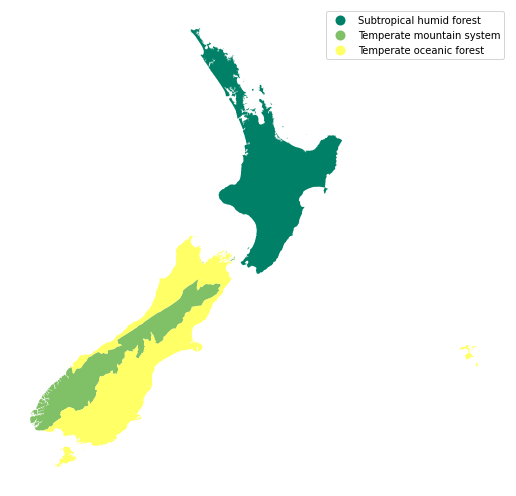

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(9, 9));
nz_gez.plot(ax=ax, column='gez_name', cmap = 'summer', legend=True)

plt.axis('off')
plt.show()

### Findings:


<dl>
<dt>North Island:</dt>
<dd>'Subtropical Humid Forest', which occurs in relatively warm climate with equal distribution of rainfall.
    The entire North Island comprises of Subtropical Humid Forest, making the analysis eaiser on this Island.</dd> </dl>
<dl>
<dt>South Island:</dt>
<dd> 'Temperate Mountain System' and as the name suggests it rightly along the Southern Alps region; alongwith 'Temperate Oceanic Forest' spread in the rest of the region. </dd>
</dl>

### #3: Climate Zones

In [16]:
climate

,CLASS_NAME,geometry
0,0,"MULTIPOLYGON (((-37.65000 83.50000, -37.65000 ..."
1,0,"MULTIPOLYGON (((-38.75000 83.40000, -38.75000 ..."
2,0,"MULTIPOLYGON (((-38.60000 83.40000, -38.60000 ..."
3,0,"MULTIPOLYGON (((-37.15000 83.40000, -37.15000 ..."
4,5,"MULTIPOLYGON (((-40.40000 83.40000, -40.40000 ..."
...,...,...
26160,1,"MULTIPOLYGON (((-26.35000 -58.40000, -26.35000..."
26161,1,"MULTIPOLYGON (((-26.65000 -59.00000, -26.65000..."
26162,1,"MULTIPOLYGON (((-27.40000 -59.40000, -27.40000..."
26163,1,"MULTIPOLYGON (((-27.25000 -59.40000, -27.25000..."


In [20]:
classification = {'1': 'Warm Temperate Moist', '2': 'Warm Temperate Dry', 
                          '3': 'Cool Temperate Moist', '4': 'Cool Temperate Dry', 
                          '5': 'Polar Moist', '6': 'Polar Dry',
                          '7': 'Boreal Moist', '8': 'Boreal Dry',
                          '9': 'Tropical Montane'}

# normalizing column name
climate.rename(columns={'CLASS_NAME': 'class_name'}, inplace=True)

# treating oceans
climate = climate[climate.class_name != '0']

# using defined class names and replacing them to the corresponding codes
climate.class_name = climate.class_name.astype('str').replace(classification)

climate.columns = climate.columns.str.lower()

In [21]:
climate_nz = climate.clip(nz)

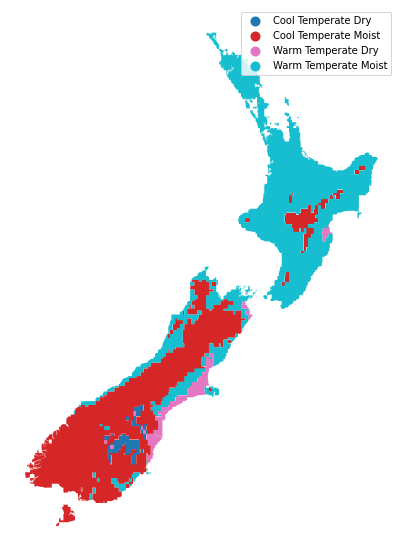

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10));
climate_nz.plot(ax=ax, column='class_name', legend=True)

plt.axis('off')
plt.show()

### #4: Soil Cover

In [23]:
# normalizing column name
soil.rename(columns={'IPCC': 'ipcc'}, inplace=True)

# clipping the nz region from soil_nz using the geometry from 'nz'
soil_nz = soil.clip(nz)

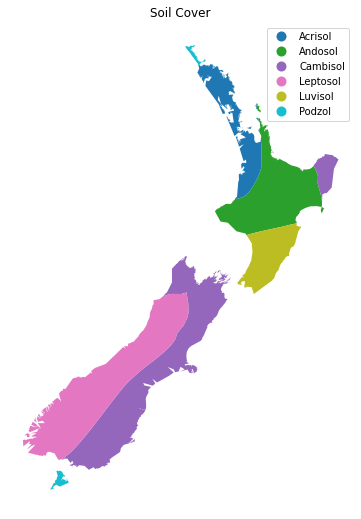

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(9, 9));
soil_nz.plot(ax=ax, column='ipcc', legend=True)
ax.set_title("Soil Cover")
plt.axis('off')
plt.show()

### #5: Holdridge Zones

In [25]:
# clipping the nz region from holdridge_zones_nz using the geometry from 'nz'
holdridge_zones_nz = holdridge_zones.clip(nz)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 14));
holdridge_zones_nz.plot(ax=ax, column='DESC', legend=True, cmap='Set3')
ax.set_title("Holdridge Zones")
plt.axis('off')
plt.show()

### #6: AgroEcological Zones

In [26]:
values = {'1': 'Steep terrain', '2': 'Artic/Cold', '3': 'Desert/Arid', 
          '4': 'Irrigated Soils', '5': 'Hydromorphic soils', 
          '6': 'Dry, good soils', '7': 'Dry, moderate soils', '8': 'Dry, poor soils', 
          '9': 'Moist, good soils', '10': 'Moist, moderate soils', 
          '11': 'Moist, poor soils', '12': 'Sub-humid, good soils', 
          '13': 'Sub-humid, moderate soils', '14': 'Sub-humid, poor soils', 
          '15': 'Humid, good soils', '16': 'Humid, moderate soils', 
          '17': 'Humid, poor soils', '18': 'Water'}

# # normalizing column name
agroecological_zones.rename(columns={'Value': 'value'}, inplace=True)

# using defined values and replacing them to the corresponding codes
agroecological_zones.value = agroecological_zones.value.astype('str').replace(values)

In [27]:
agroecological_zones_nz = agroecological_zones.clip(nz)

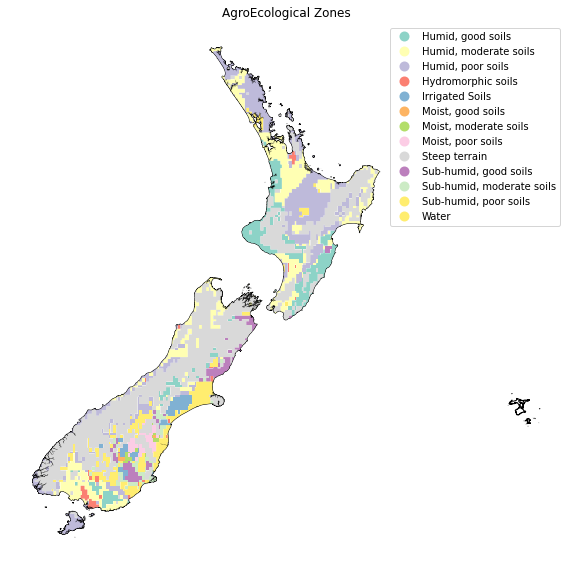

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10));
nz.plot(ax=ax, color='none', legend=True)
agroecological_zones_nz.plot(ax=ax, column='value', legend=True, cmap='Set3')
ax.set_title("AgroEcological Zones")
plt.axis('off')
plt.show()

### Plotting Climate Zones, Soil Cover, Holdridge & Agro-Ecological Zones:

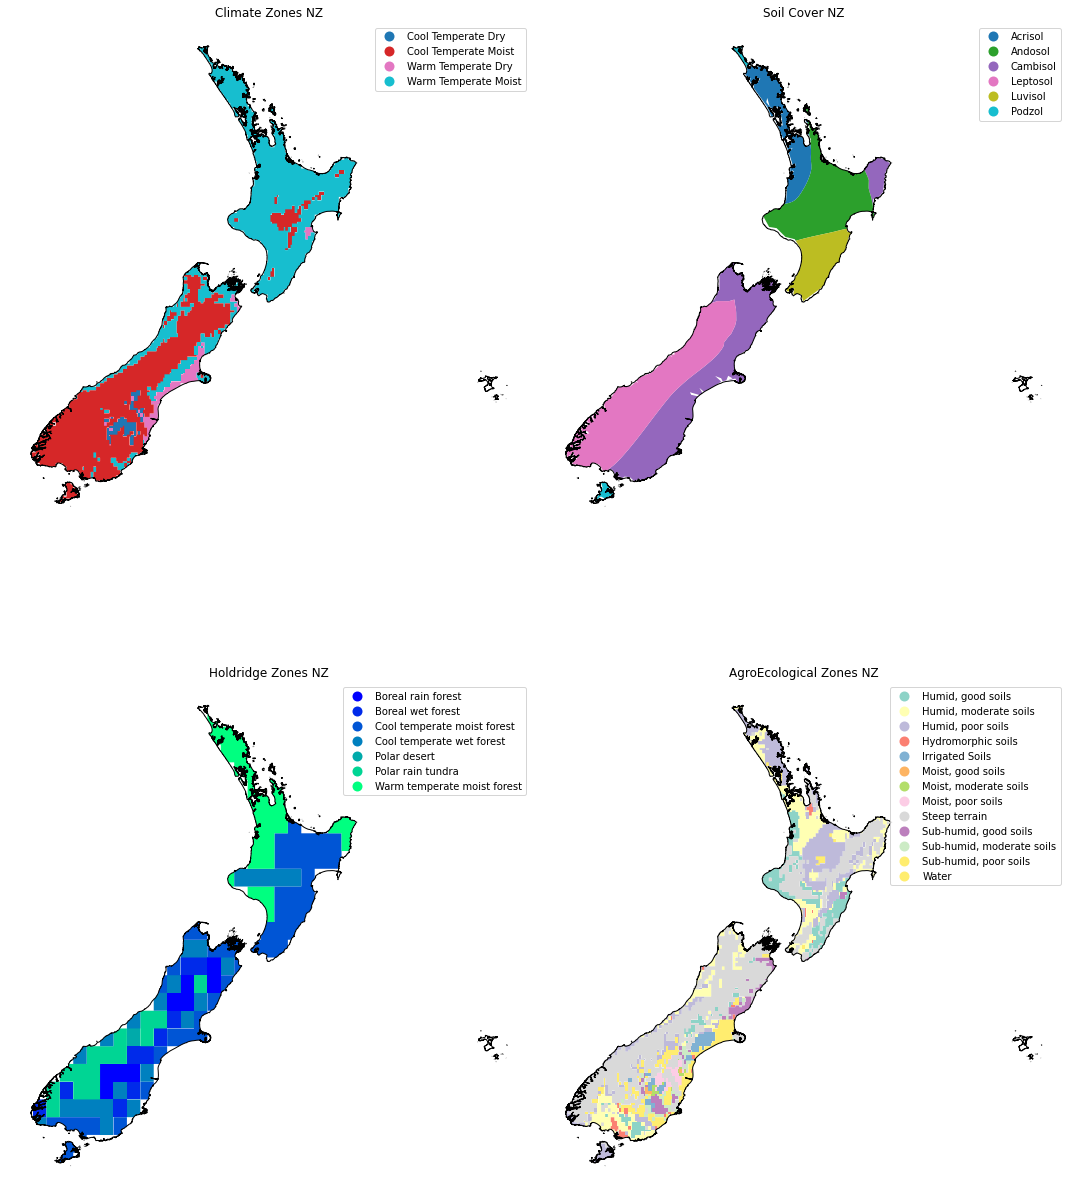

In [29]:
fig, ax = plt.subplots(2, 2, figsize=(15, 20))

climate_nz.plot(ax=ax[0][0], column='class_name', legend=True)
soil_nz.plot(ax=ax[0][1], column='ipcc', legend=True)
holdridge_zones_nz.plot(ax=ax[1][0], column='DESC', cmap='winter', legend=True)
agroecological_zones_nz.plot(ax=ax[1][1], column='value', cmap='Set3', legend=True)

ax[0][0].set_title("Climate Zones NZ")
ax[0][1].set_title("Soil Cover NZ")
ax[1][0].set_title("Holdridge Zones NZ")
ax[1][1].set_title("AgroEcological Zones NZ")

for i in range(2):
    for j in range(2):
        nz.plot(figsize=(20, 10), color='none', ax=ax[i][j])
        ax[i][j].axis('off')

plt.tight_layout()
plt.show()

### Findings:
- Climate Zone:
    - North Island/Subtropical Humid Forest: The North Island mainly has **'Warm Temperate Moist' climate with a small 'Cool Temperate Moist' zone near Lake Taupo whose surface area is about the same size as Singapore**.
    - South Island: The climate in the Southern region is 'Cool Temperate Moist' in **Temperate Mountain System with 'Warm Temperate Dry' zone along the eastern coast.**
    
- Soil Cover:
    - North Island/Subtropical Humid Forest: Mainly consisting of **Andosol (often found in Volcanic Areas and are fertile with high capacity of accumulating carbon)**, Luvisol, Acrisol & Cambisol.
    - South Island: This region consists of almost equal proportions of **Leptosol (these are shallow soils formed typically on hard rock or highly calcareous materials) & Cambisol**.
    
- Holdridge Zones:
    - North Island/Subtropical Humid Forest: This region consists of an equal proportion of 'Warm Temperate & Cool Temperate Moist Forests'.
    - South Island: The southern region has mixed zones and consists of 'Polar Rain Tundra' & 'Temperate Wet & Moist Forests'.
    
- AgroEcological Zones:
    - North Island/Subtropical Humid Forest: This region has got mostly 'Humid Moderate & Poor Soil', **'Humid Good Soil' are distrubuted in small proportions along the eastern and western coastal region** **with 'Steep Terrain' in central part of the Island**.
    - South Island: The southern island is **mostly covered by 'Steep Terrain'**, **this region has got 'Sub-humid Soil' & 'Water' on the eastern coastal region. Patches of Good, Hydromorphic & Irrigated Soil can be well spotted on the in the southern part of this Island.**

### #7: Climate Data

### #7.1 Annual Mean Temperature

In [31]:
#reading the downloaded tif file (mentioned in references)
avg_temp_tif = r'wc2.1_5m_bio\wc2.1_5m_bio_1.tif'
temp_tif = rst.open(avg_temp_tif)

In [32]:
# clipping nz from tif
nz_temp, nz_transform = mask(temp_tif, [geom for geom in nz.geometry], crop=True, pad=True)
nz_meta = temp_tif.meta

# saving the clipped raster
nz_meta.update({"driver": "GTiff",
                 "height": nz_temp.shape[1],
                 "width": nz_temp.shape[2],
                 "transform": nz_transform})

with rst.open(r'temp_clipped.tiff', 'w', **nz_meta) as dest:
    dest.write(nz_temp)

In [33]:
# reading the clipped and saved nz raster
nz_temp_tif = r'temp_clipped.tiff'
nz_temp_img = rst.open(nz_temp_tif)
arr = nz_temp_img.read(1)
arr = np.where(arr < -10, np.nan, arr)

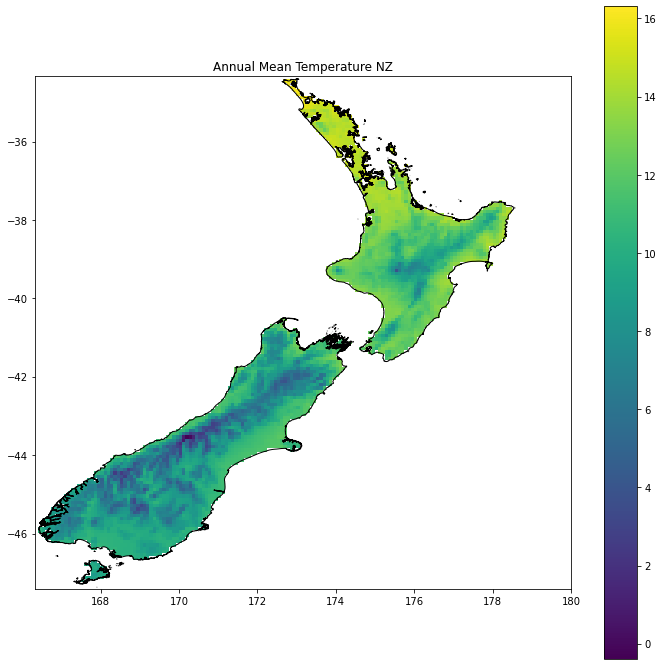

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12));
nz.plot(ax=ax, color='none', legend=True)
show(arr, transform=nz_temp_img.transform, ax=ax)
ax.set_title("Annual Mean Temperature NZ")
fig.colorbar(cm.ScalarMappable(norm=colors.Normalize(vmin=np.nanmin(arr), vmax=np.nanmax(arr))), ax=ax)
plt.show()

### Findings:
- Annual Mean Temperature on the North Island is relatively higher than that on the South Island, the **strip of Steep Terrain on South Island hosting the Southern Alps with Polar Rain Tundra zone (as analyzed from Holdridge & Agro-Ecological data) has got the minimum mean temperature, falling below 6°C or 42F.** 
- On the North Island, **Northland, Auckland & Waikato with Warm Temperate Moist Forest & Tropical Montane Climate** have the **highest mean temperature and ranges between 10-16°C.**

### #7.2 Annual Mean Precipitation

In [35]:
#reading the downloaded tif file (mentioned in references)
avg_ppt_tif = r'wc2.1_5m_bio\wc2.1_5m_bio_12.tif'
ppt_tif = rst.open(avg_ppt_tif)

In [36]:
# clipping nz from tif
nz_ppt, nz_transform = mask(ppt_tif, [geom for geom in nz.geometry], crop=True, pad=True)
nz_meta = ppt_tif.meta

# saving the clipped raster
nz_meta.update({"driver": "GTiff",
                 "height": nz_ppt.shape[1],
                 "width": nz_ppt.shape[2],
                 "transform": nz_transform})

with rst.open(r'ppt_clipped.tiff', 'w', **nz_meta) as dest:
    dest.write(nz_ppt)

In [37]:
# reading the clipped and saved nz raster
nz_ppt_tif = r'ppt_clipped.tiff'
nz_ppt_img = rst.open(nz_ppt_tif)
arr = nz_ppt_img.read(1)
arr = np.where(arr < -10, np.nan, arr)

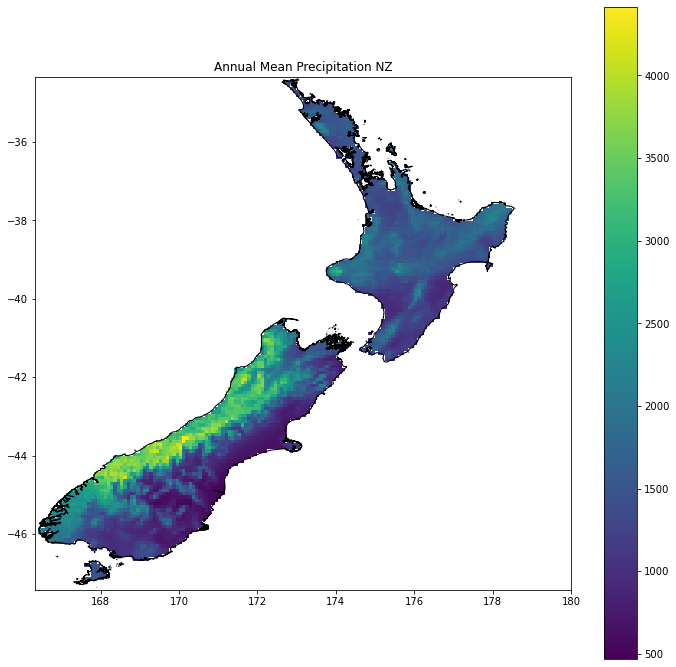

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12));
nz.plot(ax=ax, color='none', legend=True)
show(arr, transform=nz_ppt_img.transform, ax=ax)
ax.set_title("Annual Mean Precipitation NZ")
fig.colorbar(cm.ScalarMappable(norm=colors.Normalize(vmin=np.nanmin(arr), vmax=np.nanmax(arr))), ax=ax)
plt.show()

### Findings:
- North Island seems to be receiving moderate rainfall over the entire region.
- Annual Mean Precipitation on the South Island seems to be really heavy over the Southern Alps as it falls in the Polar Rain Tundra zone, the precipitation on the eastern coastal region seems to be the minimum throughout the year.

#### References, Sources & Datasets:
- Studying the geographical area: https://www.google.com/maps/search/north+island/@-44.2402653,168.780076,7.18z?hl=en-US; https://niwa.co.nz/education-and-training/schools/resources/climate/overview
- Section 1.1 & 1.2: https://en.wikipedia.org/wiki/File:NZ_Territorial_Authorities_North_Island.png; https://en.wikipedia.org/wiki/File:NZ_Territorial_Authorities_South_Island.png
- Datasets: https://datasets.mojaglobal.workers.dev/0:/
- Section 7, Climate Dataset (tif) (WorldClim Historical Climate Data): https://www.worldclim.org/data/worldclim21.html 